In [2]:
"""
sets.ipynb

Jupyter Notebook to perform analysis on card sets.

Author: Jordan Bourdeau, Casey Forey
Date Created: 4/7/24
"""

'\nsets.ipynb\n\nJupyter Notebook to perform analysis on card sets.\n\nAuthor: Jordan Bourdeau, Casey Forey\nDate Created: 4/7/24\n'

In [33]:
# Imports
from importlib import reload
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import IsolationForest
from statsmodels.stats.proportion import proportions_ztest

from src import constants as c
from src.calculate import calculate_market_data as cmd
from src.calculate import calculate_set_data as csd
from src.load import load_card_data as lcd
from src.load import load_set_data as lsd
from src.load import load_utils
from src.plot import plot_set_data as psd
from src.plot import plot_utils

In [4]:
reload(load_utils)

# Load dataset
all_printings_filepath: str = os.path.join(c.DATA_DIRECTORY, 'AllPrintings.json')
all_printings: dict = load_utils.load_json_data(all_printings_filepath)

In [5]:
reload(lsd)

sets = lsd.load_set_and_release_year()
sets[sets['set_code'] == 'LTR']

,set_code,set_name,release_year,release_month,set_size
652,LTR,The Lord of the Rings: Tales of Middle-earth,2023,6,289


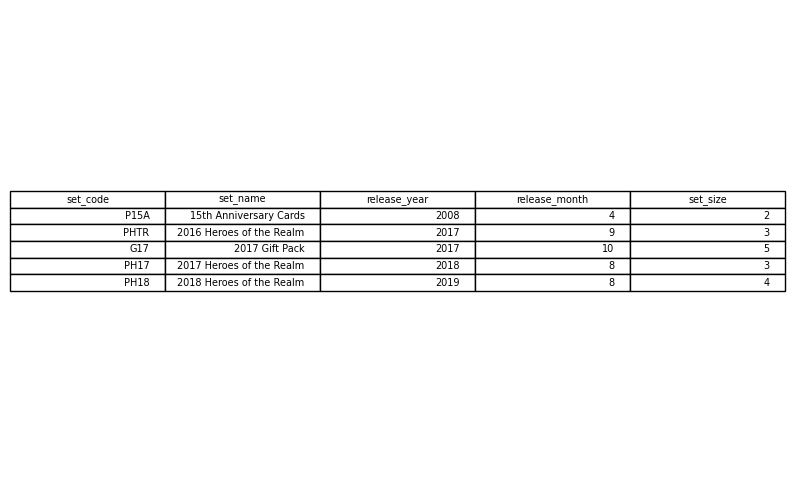

In [6]:
plot_utils.plot_dataframe_as_table(sets.head(), os.path.join(c.IMAGE_DIRECTORY, 'original_set_list_df.png'))

In [7]:
reload(lsd)

lsd.save_format_set_ban_counts(all_printings, 'modern')

In [8]:
reload(lcd)

df = lcd.load_first_card_printing_in_format('modern', all_printings)
df

,card_name,set_name,set_code,release_year,release_month
0,Boundary Lands Ranger,Wilds of Eldraine,WOE,2023.0,9.0
1,Haunter of Nightveil,Dragon's Maze,DGM,2013.0,5.0
2,A-Cabaretti Charm,Streets of New Capenna,SNC,2022.0,4.0
3,Disentomb,Magic 2010,M10,2009.0,7.0
4,Uncaged Fury,Shadows over Innistrad,SOI,2016.0,4.0
...,...,...,...,...,...
28668,Griptide,Dark Ascension,DKA,2012.0,2.0
28669,Kill! Destroy!,NaN,NaN,NaN,NaN
28670,Thermo-Alchemist,Eldritch Moon,EMN,2016.0,7.0
28671,Noble Elephant,NaN,NaN,NaN,NaN


In [9]:
reload(lsd)

# Augmenting set data with tournament data and number of banend cards
set_card_usages_and_bans: pd.DataFrame = lsd.load_augmented_set_data(all_printings, 'modern')

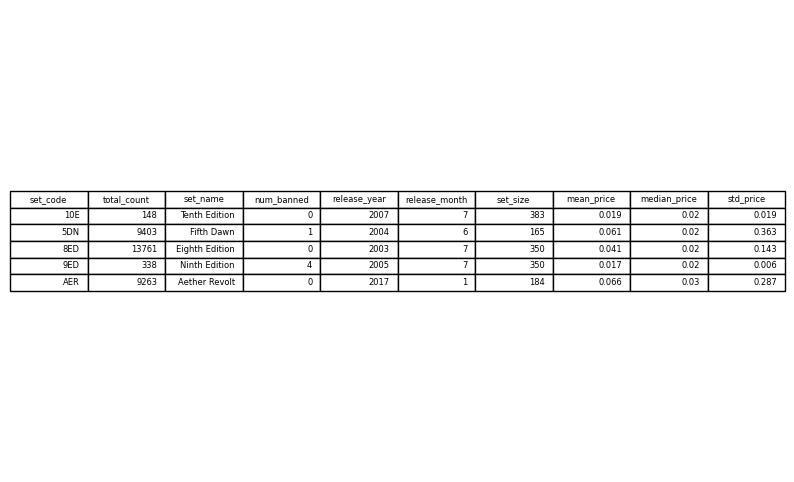

In [10]:
plot_utils.plot_dataframe_as_table(set_card_usages_and_bans.head(), os.path.join(c.IMAGE_DIRECTORY, 'augmented_set_df.png'))

In [11]:
reload(csd)

np.random.seed(0)

# Selecting numerical columns to train the model on
columns_for_model = ['total_count', 'num_banned', 'set_size', 'mean_price', 'median_price', 'std_price']
data_for_model = set_card_usages_and_bans[columns_for_model]

outliers = csd.find_set_outliers(set_card_usages_and_bans, columns_for_model)

print(f'Found {len(outliers)} outliers')
outliers_after_fire_design: pd.DataFrame = outliers[outliers['release_year'] >= 2019]
print(f'{(len(outliers_after_fire_design) / len(outliers)) * 100:.2f}% of outlier sets came after the fire design principle.')
outliers.head()

Found 9 outliers
77.78% of outlier sets came after the fire design principle.


,set_code,total_count,set_name,num_banned,release_year,release_month,set_size,mean_price,median_price,std_price
38,KTK,36477,Khans of Tarkir,2,2014,9,269,0.176,0.02,1.152
39,LCI,743,The Lost Caverns of Ixalan,0,2023,11,291,0.238,0.01,1.314
41,LTR,22331,The Lord of the Rings: Tales of Middle-earth,0,2023,6,289,0.336,0.03,3.690
49,M20,6841,Core Set 2020,1,2019,7,280,0.449,0.03,1.560
51,MAT,437,March of the Machine: The Aftermath,0,2023,5,50,0.135,0.02,0.395


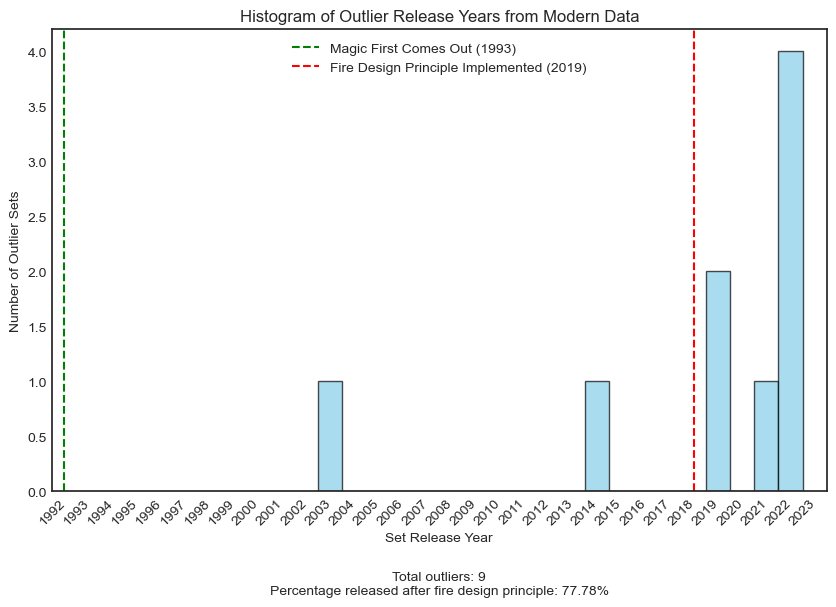

In [29]:
reload(psd)

psd.plot_outlier_distribution(outliers, 'modern')

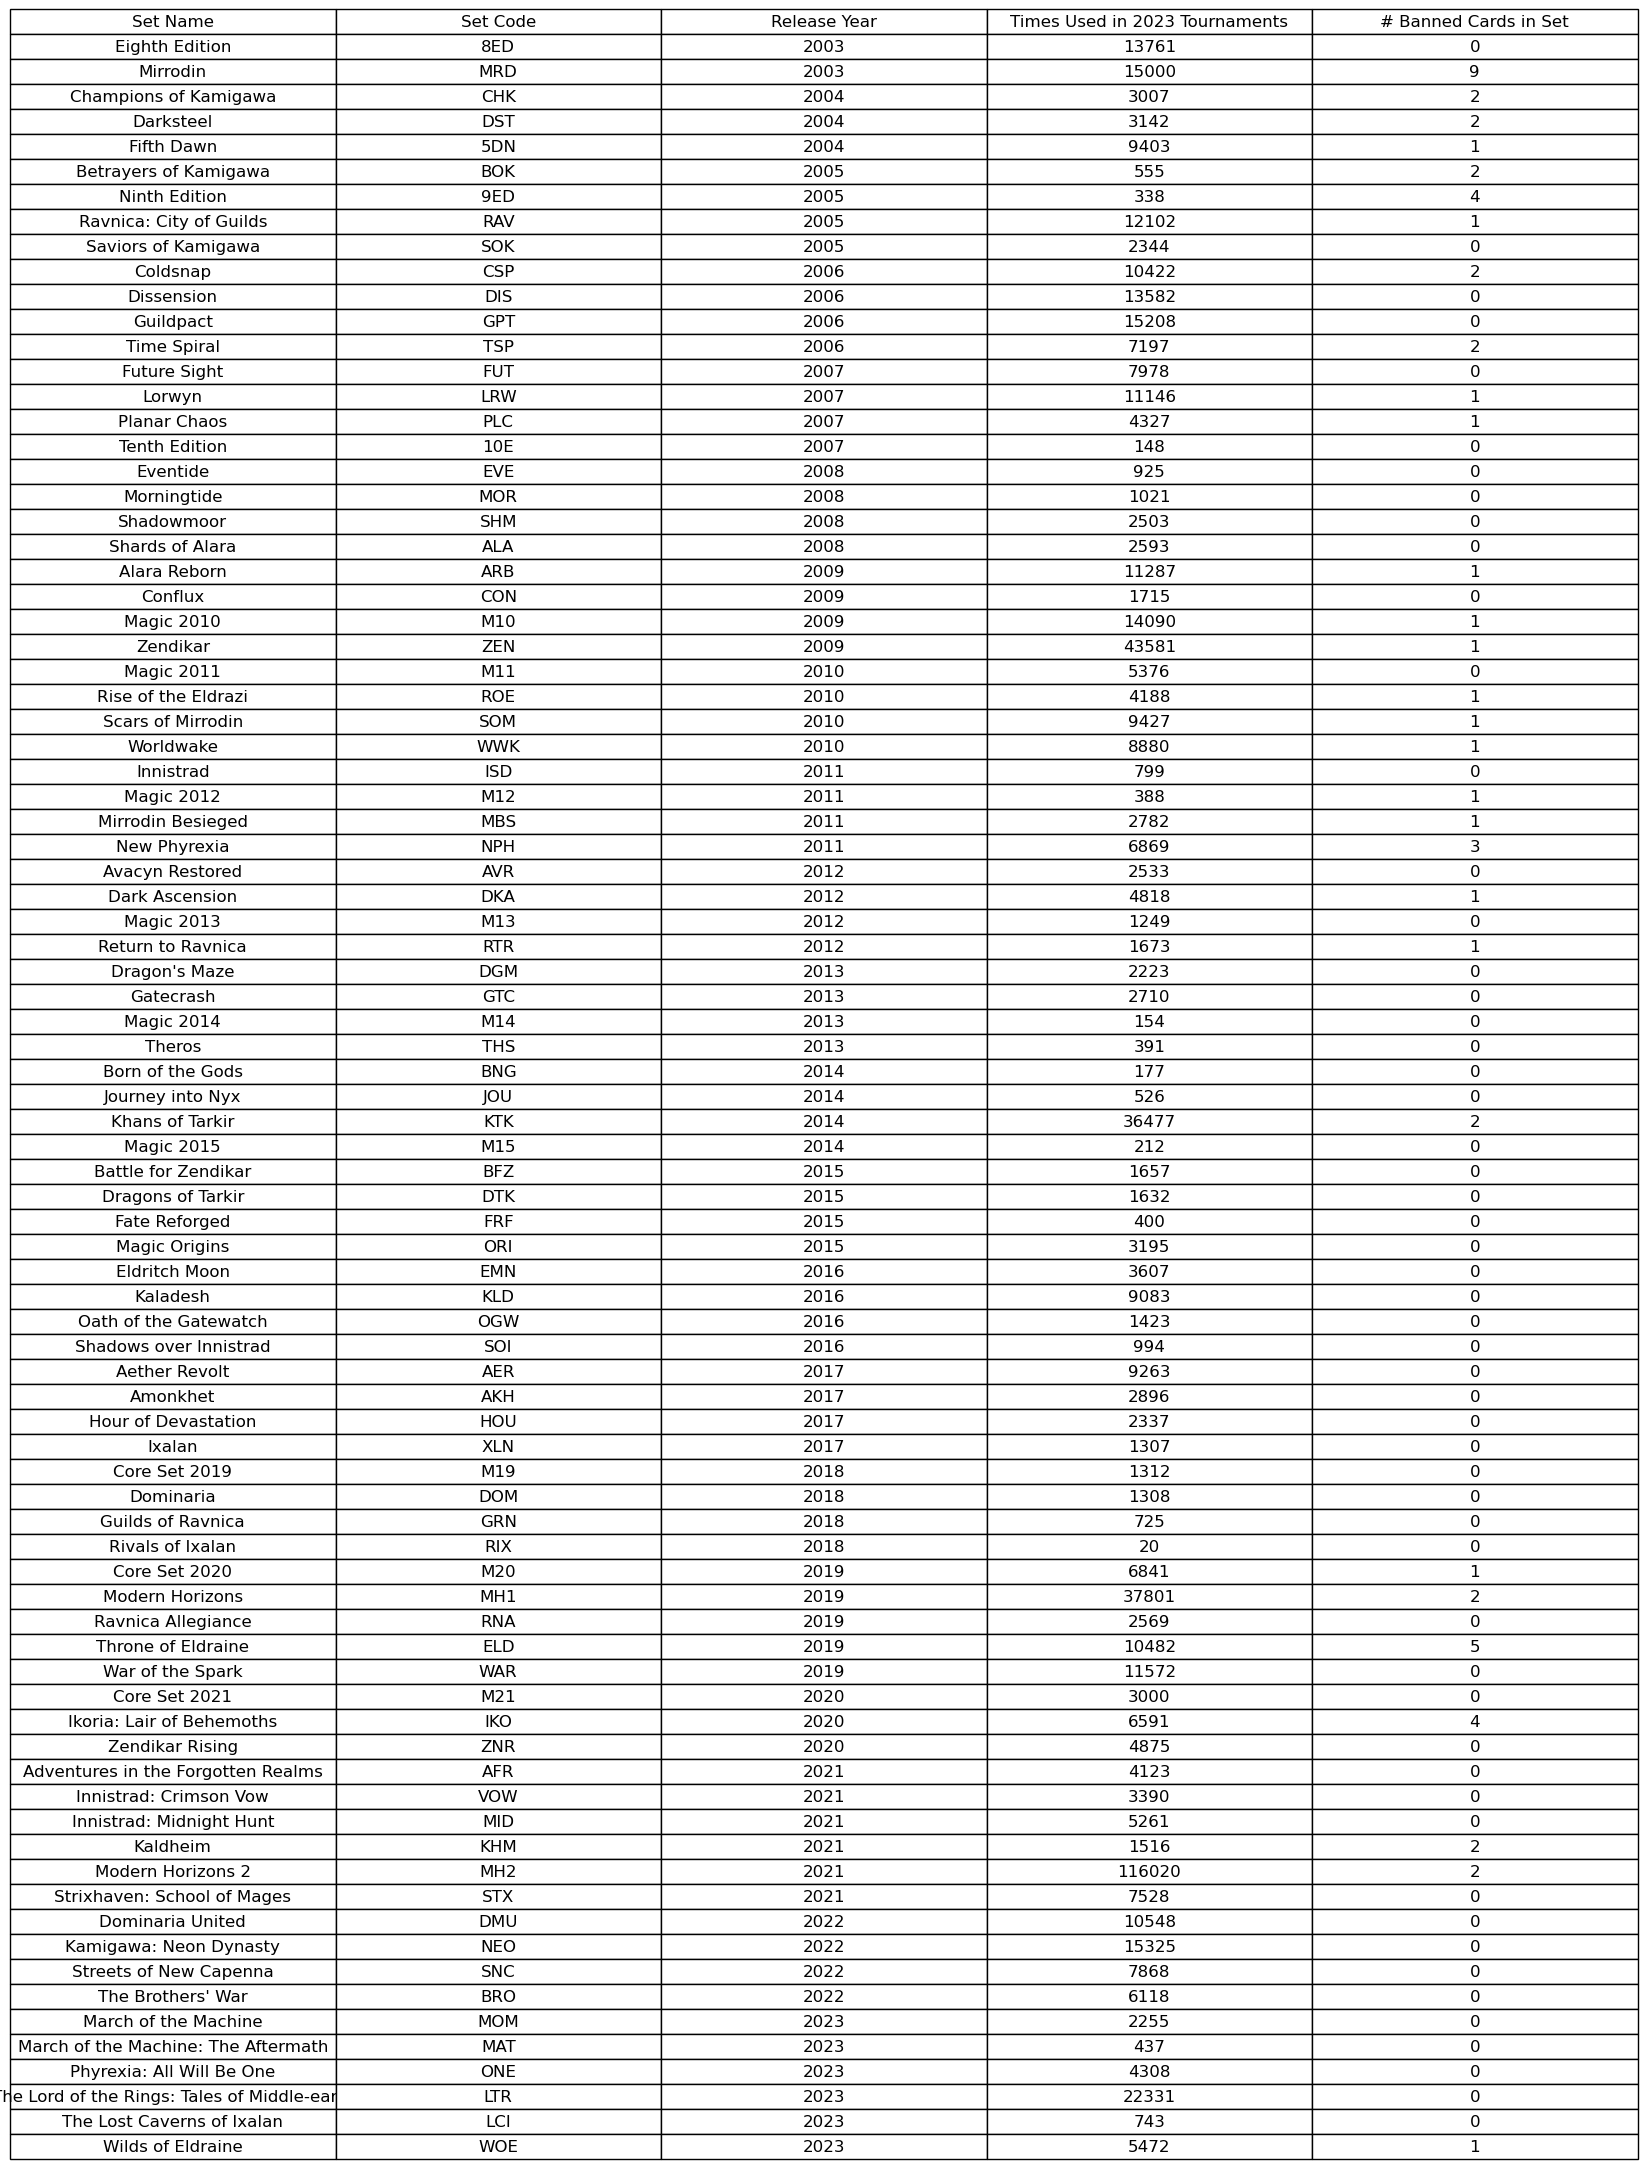

In [13]:
reload(psd)

psd.plot_set_table(set_card_usages_and_bans)

In [49]:
# Do two-sample proportion z-test on number of outliers
num_sets_per_year_df: pd.DataFrame = set_card_usages_and_bans \
    .groupby(['release_year']) \
    .size() \
    .reset_index() \
    .rename(columns={0: 'count'})

sets_after_2019: int = num_sets_per_year_df[num_sets_per_year_df['release_year'] >= 2019]['count'].sum()
sets_before_2019: int = num_sets_per_year_df[num_sets_per_year_df['release_year'] < 2019]['count'].sum()

print(f'Number of sets before 2019: {sets_before_2019}')
print(f'Number of sets after 2019: {sets_after_2019}')

outliers_grouped_by_year: pd.DataFrame = outliers \
    .groupby(['release_year']) \
    .size() \
    .reset_index() \
    .rename(columns={0: 'count'})

outliers_after_2019: int = outliers_grouped_by_year[outliers_grouped_by_year['release_year'] >= 2019]['count'].sum()
outliers_before_2019: int = outliers_grouped_by_year[outliers_grouped_by_year['release_year'] < 2019]['count'].sum()

print(f'Number of outliers before 2019: {outliers_before_2019}')
print(f'Number of outliers after 2019: {outliers_after_2019}')

expected_proportion: float = sets_after_2019 / (sets_after_2019 + sets_before_2019)
actual_proportion: float = outliers_after_2019 / (outliers_after_2019 + outliers_before_2019)

print(f'Expected Proportion of Outliers after 2019: {expected_proportion * 100:.2f}%')
print(f'Actual Proportion of Outliers after 2019: {actual_proportion * 100:.2f}%')

# Perform z-test
count: int = outliers_after_2019
nobs: int = outliers_after_2019 + outliers_before_2019
stat, pval = proportions_ztest(count, nobs, value=expected_proportion, alternative='larger')

# Output the results
print("Test Statistic (z-score):", stat)
print("P-value:", pval)

Number of sets before 2019: 61
Number of sets after 2019: 24
Number of outliers before 2019: 2
Number of outliers after 2019: 7
Expected Proportion of Outliers after 2019: 28.24%
Actual Proportion of Outliers after 2019: 77.78%
Test Statistic (z-score): 3.5750121418167833
P-value: 0.00017510582149847742


61